In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import tensorflow as tf

In [2]:
x="Hi hello how are you"
print(len(x.split()))

5


In [3]:
url="https://raw.githubusercontent.com/Sooryak12/FakeReviewDetectionLSTM/master/selected.txt"

In [4]:
df=pd.read_csv(url,delimiter="\t")
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


In [5]:
df.isnull().sum()

DOC_ID               0
LABEL                0
RATING               0
VERIFIED_PURCHASE    0
PRODUCT_CATEGORY     0
PRODUCT_ID           0
PRODUCT_TITLE        0
REVIEW_TITLE         0
REVIEW_TEXT          0
dtype: int64

In [6]:
df["PRODUCT_CATEGORY"].value_counts()

Electronics               700
Automotive                700
Lawn and Garden           700
Home Entertainment        700
PC                        700
Baby                      700
Musical Instruments       700
Office Products           700
Beauty                    700
Camera                    700
Home Improvement          700
Tools                     700
Jewelry                   700
Grocery                   700
Wireless                  700
Furniture                 700
Books                     700
Pet Products              700
Shoes                     700
Home                      700
Sports                    700
Apparel                   700
Video DVD                 700
Video Games               700
Luggage                   700
Watches                   700
Kitchen                   700
Toys                      700
Health & Personal Care    700
Outdoors                  700
Name: PRODUCT_CATEGORY, dtype: int64

In [7]:
df.columns

Index(['DOC_ID', 'LABEL', 'RATING', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY',
       'PRODUCT_ID', 'PRODUCT_TITLE', 'REVIEW_TITLE', 'REVIEW_TEXT'],
      dtype='object')

In [8]:
df.iloc[5]

DOC_ID                                                               6
LABEL                                                       __label1__
RATING                                                               3
VERIFIED_PURCHASE                                                    N
PRODUCT_CATEGORY                                Health & Personal Care
PRODUCT_ID                                                  B00686HNUK
PRODUCT_TITLE        Tobacco Pipe Stand - Fold-away Portable - Ligh...
REVIEW_TITLE                                                  not sure
REVIEW_TEXT          I'm not sure what this is supposed to be but I...
Name: 5, dtype: object

In [9]:
df["LABEL"]=df["LABEL"].replace(['__label2__','__label1__'],['l2','l1'])

In [10]:
data1=df[df["LABEL"]=="l2"]
data1.reset_index(drop=True,inplace=True)

In [11]:
data2=df[df["LABEL"]=="l1"]
data2.reset_index(drop=True,inplace=True)

In [12]:
data2["REVIEW_TEXT"][8]

"I've used tide pods laundry detergent for many years,its such a great detergent to use having a nice scent and leaver the cloths smelling fresh."

In [13]:
data1["REVIEW_TEXT"][10]

"I can understand the premise and I like the premise.<br />However, I just don't believe that these bibs are comfortable for baby.<br /><br />While they are not hard, they are not soft.<br /><br />The Oxo Tot Roll Up bib has a truly soft front with a catch for whatever doesn't make it into baby's mouth.  It also has a flat velcro closure as opposed to Babybjorn's plastic snap closure.<br /><br />Babybjorn can be cleaned off easier, while Oxo would need to be washed when truly soiled.<br />But...Oxo can be rolled up for travel."

In [28]:
data1["REVIEW_TEXT"]=data1["REVIEW_TEXT"].apply(preprocess_text)
data1["REVIEW_TEXT"]=data1["REVIEW_TEXT"].apply(remove_tags)

C:\Users\soory\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\soory\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
data1["REVIEW_TEXT"][10]

'I can understand the premise and like the premise However just don believe that these bibs are comfortable for baby While they are not hard they are not soft The Oxo Tot Roll Up bib has truly soft front with catch for whatever doesn make it into baby mouth It also has flat velcro closure as opposed to Babybjorn plastic snap closure Babybjorn can be cleaned off easier while Oxo would need to be washed when truly soiled But Oxo can be rolled up for travel '

In [10]:
dfs=df[["REVIEW_TEXT","LABEL","PRODUCT_CATEGORY"]]
dfs = dfs.rename(columns={'REVIEW_TEXT': 'reviews',"LABEL":"label","PRODUCT_CATEGORY":"cat"})

In [11]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  21000 non-null  object
 1   label    21000 non-null  object
 2   cat      21000 non-null  object
dtypes: object(3)
memory usage: 492.3+ KB


In [12]:
dfs["label"].value_counts()

0    10500
1    10500
Name: label, dtype: int64

In [13]:
dfs["label"]=dfs["label"].astype(np.float32)

In [26]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [27]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [16]:
dfs["reviews"]=dfs["reviews"].apply(preprocess_text)

In [17]:
dfs["reviews"]=dfs["reviews"].apply(remove_tags)

In [18]:
dfs["reviews"]

0        When least you think so this product will save...
1        Lithium batteries are something new introduced...
2        I purchased this swing for my baby She is mont...
3        I was looking for an inexpensive desk calcolat...
4        I only use it twice week and the results are g...
                               ...                        
20995    I bought these for work have high arches so us...
20996    Crocs are one of only two brands of shoes that...
20997    I love moccasins This fit like it was custom m...
20998    I wish these were little more durable got it c...
20999    I ve been looking for replacement for my belov...
Name: reviews, Length: 21000, dtype: object

In [19]:
dfs["len_review"]=dfs["reviews"].apply(lambda x :len(x.split()))

In [20]:
max(dfs["len_review"])

2793

In [21]:
def category(x):
    if 0<x<11:
        return 5
    elif 10<x<21:
        return 15
    elif 20<x<31:
        return 25
    elif 30<x<41:
        return 35
    elif 40<x<50:
        return 45
    elif 50<x<61:
        return 55
    elif 60<x<101:
        return 80
    elif 100<x<301:
        return 150
    elif 300<x<601:
        return 450
    elif 600<x<1001:
        return 800
    elif 1000<x<1501:
        return 1250
    elif 1500<x<2001:
        return 1750
    elif 2000<x<2600:
        return 2300
    

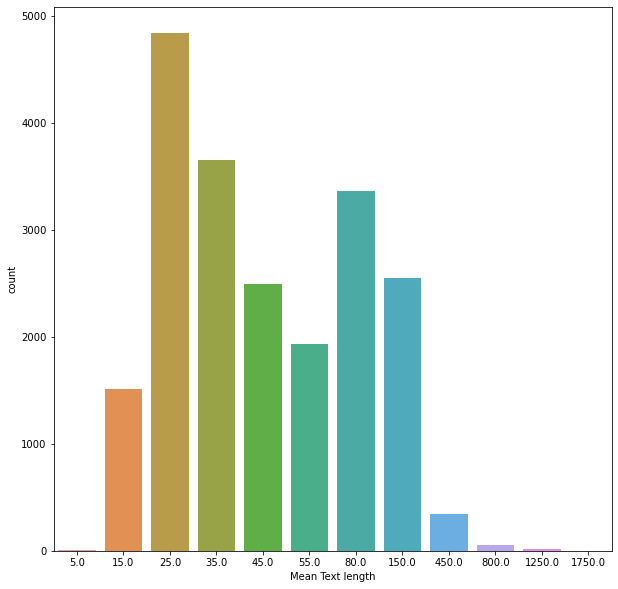

In [22]:
dfs["textcat"]=dfs["len_review"].apply(category)
plt.figure(figsize=(10,10))
ax=sns.countplot(dfs["textcat"])
ax.set(xlabel="Mean Text length")
plt.show()

In [23]:
np.median(dfs["len_review"])

42.0

In [24]:
c=0
for i in dfs["len_review"]:
    if 150<i:
      c+=1
print(c)

1515


In [25]:
1515/21000

0.07214285714285715

In [26]:
dfse=dfs[dfs["len_review"]<150]

In [27]:
dfse.reset_index(drop=True,inplace=True)

In [28]:
dfse["reviews"]=dfse["reviews"].str.lower()

C:\Users\soory\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
dfse["reviews"][789]

'this was the first wallet that valued so far it has plenty of room for the cards and important receipts inside it also serves as dual purpose because there a room for phone and for make up would definitely buy this again '

In [30]:
from nlppreprocess import NLP

In [31]:
nlp=NLP

In [32]:
obj=NLP(remove_stopwords=True,remove_numbers=True)

In [33]:
dfse["reviews"]=dfse["reviews"].apply(obj.process)

C:\Users\soory\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
dfse["reviews"][789]

'first wallet valued far plenty room cards and important receipts inside also serves dual purpose because there room phone and make up would definitely buy again'

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding='utf8')

In [37]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [38]:
df_train,df_test,Ytrain,Ytest = train_test_split(dfse["reviews"],dfse["label"], test_size=0.2, random_state=43)

In [39]:
MAX_VOCAB_SIZE=30000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,oov_token="<OOV>")
tokenizer.fit_on_texts(df_train)

In [40]:
word2idx=tokenizer.word_index
len(word2idx)

23151

In [ ]:
MAX_VOCAB_SIZE=30000

In [41]:
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [46]:
data_train = pad_sequences(sequences_train,maxlen=128)
print('Shape of data train tensor:',data_train.shape)
T = data_train.shape[1]

Shape of data train tensor: (15572, 128)


In [47]:
data_test = pad_sequences(sequences_test,maxlen=T)
print('Shape of data test tensor:',data_test.shape)

Shape of data test tensor: (3893, 128)


In [48]:
embedding_matrix = np.zeros((MAX_VOCAB_SIZE, 100))
for word, index in tokenizer.word_index.items():
    if index > MAX_VOCAB_SIZE - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [49]:
max_len=128

In [51]:
from tensorflow.keras.layers import Dropout,Conv1D,MaxPooling1D

In [76]:
model_glove = Sequential()
model_glove.add(Embedding(MAX_VOCAB_SIZE, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
r=model_glove.fit(data_train, np.array(Ytrain), validation_data=(data_test,Ytest), epochs = 20)

ValueError: Error when checking input: expected embedding_11_input to have shape (40,) but got array with shape (128,)

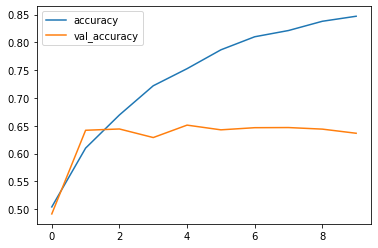

In [53]:
plt.plot(r.history["accuracy"],label="accuracy")
plt.plot(r.history["val_accuracy"],label="val_accuracy")
plt.legend()

In [54]:
r=model_glove.fit(data_train, np.array(Ytrain), validation_data=(data_test,Ytest), epochs = 15)

Train on 15572 samples, validate on 3893 samples
Epoch 1/15
15572/15572 [==============================] - 37s 2ms/sample - loss: 0.5598 - accuracy: 0.8548 - val_loss: 0.6609 - val_accuracy: 0.6322
Epoch 2/15
15572/15572 [==============================] - 58s 4ms/sample - loss: 0.5525 - accuracy: 0.8728 - val_loss: 0.6737 - val_accuracy: 0.6427
Epoch 3/15
15572/15572 [==============================] - 55s 4ms/sample - loss: 0.5517 - accuracy: 0.8733 - val_loss: 0.6634 - val_accuracy: 0.6450
Epoch 4/15
15572/15572 [==============================] - 52s 3ms/sample - loss: 0.5483 - accuracy: 0.8821 - val_loss: 0.6674 - val_accuracy: 0.6450
Epoch 5/15
15572/15572 [==============================] - 41s 3ms/sample - loss: 0.5459 - accuracy: 0.8867 - val_loss: 0.6615 - val_accuracy: 0.6422
Epoch 6/15
15572/15572 [==============================] - 57s 4ms/sample - loss: 0.5434 - accuracy: 0.8929 - val_loss: 0.6774 - val_accuracy: 0.6465
Epoch 7/15
15572/15572 [==============================] -

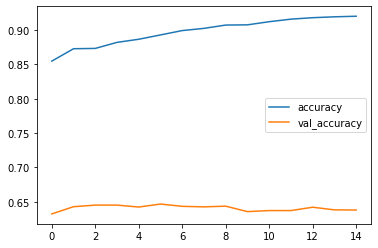

In [55]:
plt.plot(r.history["accuracy"],label="accuracy")
plt.plot(r.history["val_accuracy"],label="val_accuracy")
plt.legend()